# Step 3: Data Regression

In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ipywidgets as widgets
import plotly.express as px
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer


## Recall of data acquisition and data pre-processing

In [67]:

# Loading the dataset
file_path = "dataset/salaries.csv"  
df = pd.read_csv(file_path)

In [68]:
# Part 1: Data Cleaning

# 1. Check for Duplicates
print("\nChecking for Duplicates...")
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Drop duplicates if any
if num_duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicate rows removed.")
else:
    print("No duplicate rows found.")



# 2. Check for Missing Values
print("\nChecking for Missing Values...")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Imputation or Removal of Missing Values
# Strategy: Drop rows or Impute with mean/median
columns_with_null = missing_values[missing_values > 0].index
for column in columns_with_null:
    if df[column].dtype in ['float64', 'int64']:
        df[column].fillna(df[column].median(), inplace=True)
        print(f"Missing values in '{column}' filled with median.")
    else:
        df[column].fillna(df[column].mode()[0], inplace=True)
        print(f"Missing values in '{column}' filled with mode.")

# Final Check for Missing Values
print("\nFinal Check for Missing Values:")
print(df.isnull().sum())

unique_employee_residence = df['employee_residence'].nunique()
print("Number of unique employee residence:", unique_employee_residence)

unique_job_titles = df['job_title'].nunique()
print("Number of unique job titles:", unique_job_titles)

#Check for negative salaries 
negative_salaries = df[df['salary_in_usd'] < 0]
print("Negative Salaries:")
print(negative_salaries)

#Check for data range Check for salaries outside a specific range
salary_range = (1000, 1000000)
out_of_range_salaries = df[(df['salary_in_usd'] < salary_range[0]) | (df['salary_in_usd'] > salary_range[1])]
print("Out of Range Salaries:")
print(out_of_range_salaries)

# Drop the 'salary' column because we will only use salary_in_usd for this analysis
df = df.drop('salary', axis=1)

# Print the updated DataFrame
df.head()

# Mantieni le prime 15 categorie
top_4_categories = df['employee_residence'].value_counts().head(3).index

df['employee_residence'] = df['employee_residence'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['company_location'].value_counts().head(3).index

df['company_location'] = df['company_location'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['salary_currency'].value_counts().head(3).index

df['salary_currency'] = df['salary_currency'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['employment_type'].value_counts().head(1).index

df['employment_type'] = df['employment_type'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)



Checking for Duplicates...
Number of duplicate rows: 9333
Duplicate rows removed.

Checking for Missing Values...
Series([], dtype: int64)

Final Check for Missing Values:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64
Number of unique employee residence: 79
Number of unique job titles: 254
Negative Salaries:
Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size]
Index: []
Out of Range Salaries:
Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size]
Index: []


## Linear Regression


Pipeline without Data Leakage:


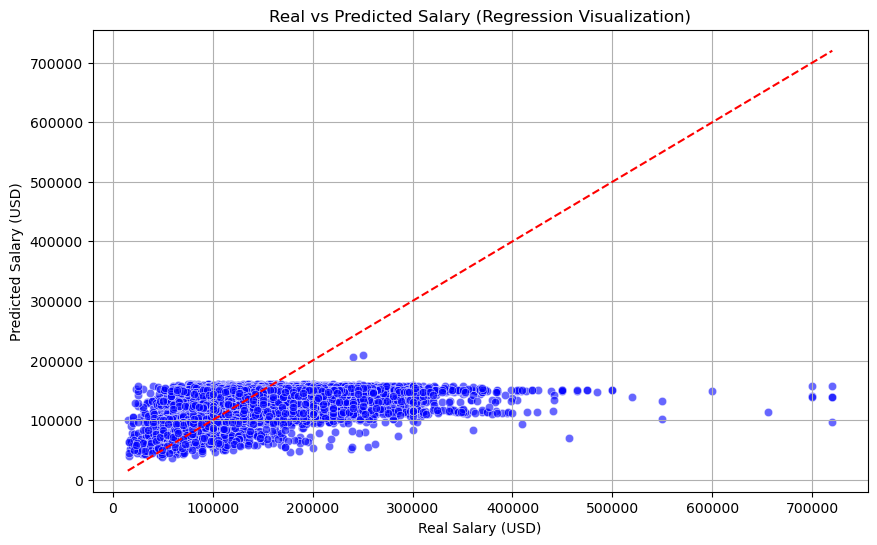


Final Model Evaluation (Without Data Leakage):
{'MAE': 44758.4803590742, 'RMSE': 61631.595988968016, 'R2': 0.11251792582176534}

X_train after preprocessing (first 5 rows):
    0    1    2    3    4    5    6    7    8    9   ...   11   12   13   14  \
0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0   
1  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
2  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
3  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0   
4  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0   

    15   16   17     18        19        20  
0  0.0  1.0  2.0  185.0  0.508336 -0.640048  
1  0.0  0.0  2.0  185.0  0.508336 -0.640048  
2  0.0  0.0  2.0  185.0  0.508336 -0.640048  
3  0.0  1.0  2.0  139.0  0.508336 -0.640048  
4  0.0  1.0  2.0  139.0  0.508336 -0.640048  

[5 rows x 21 columns]


In [69]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per valutare il modello
def evaluate_model(y_true, y_pred, apply_expm1=False):
    if apply_expm1:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Definizione delle feature
low_cardinality_features = ['employment_type', 'company_size', 'employee_residence', 'company_location', 'salary_currency']
high_cardinality_features = ['experience_level', 'job_title']
numerical_features = ['work_year', 'remote_ratio']

# Preprocessing pipelines
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, low_cardinality_features),
        ('oe', oe, high_cardinality_features),
        ('scale', scaler, numerical_features)
    ],
    remainder='passthrough'
)

# Inizializzazione K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# Pipeline con Visualizzazione dei Risultati
# ==========================================
print("\nPipeline without Data Leakage:")

y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(df):
    X = df.drop('salary_in_usd', axis=1)
    y = np.log1p(df['salary_in_usd'])  # Log-transform sul target
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline_no_leakage = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

    pipeline_no_leakage.fit(X_train, y_train)
    y_pred = pipeline_no_leakage.predict(X_test)
    
    y_pred = np.expm1(y_pred)  # Riporta alla scala originale
    y_test = np.expm1(y_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Visualizzazione con Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, color='blue')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--')

plt.title("Real vs Predicted Salary (Regression Visualization)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

# Valutazione Finale del Modello
final_results = evaluate_model(np.array(y_true_all), np.array(y_pred_all))
print("\nFinal Model Evaluation (Without Data Leakage):")
print(final_results)
X_train_transformed = preprocessor.fit_transform(X_train)
print("\nX_train after preprocessing (first 5 rows):")
print(pd.DataFrame(X_train_transformed).head())


## Why Linear Regression Performs Poorly on Salary Prediction

## 1. Why Does Linear Regression Perform Poorly?  

### 1.1 Assumption of Linearity in a Non-Linear Problem  
Linear regression assumes a **linear relationship** between the independent variables (features) and the dependent variable (salary). However, salary data often follows **complex non-linear patterns**, influenced by factors such as experience, job title, location, and market conditions.  
- **Evidence from the Plot:**  
  The scatter plot shows that for higher salaries, predictions are **consistently underestimated**. The model struggles to represent extreme values because linear regression cannot model exponential or non-linear growth.  

### 1.2 Outliers and Skewed Distribution  
Salary data frequently contains **extreme outliers** (very high salaries) that distort the model. Linear regression is **highly sensitive to outliers**, which disproportionately affect the regression line.  
- **Result:**  
  The model attempts to minimize overall error but at the cost of accuracy for high salaries, resulting in **low R² and high RMSE**.  

### 1.3 Limited Feature Representation  
The features used (work_year, remote_ratio, etc.) may **not fully capture** the driving factors behind high salaries. Elements like bonuses, stock options, and executive roles might be missing, limiting the model's predictive capacity.  
- **Impact:**  
  Linear regression relies on available features; if high-impact variables are missing, the model cannot generalize effectively.  

### 1.4 Data Imbalance (Bias Toward the Majority Class)  
Most of the data represents salaries in the lower range (<300K). Linear regression primarily fits the **majority class**, neglecting the rare cases of high salaries. This leads to a model that performs well for lower salaries but **fails to capture variance in the upper range**.  

---

## 2. Interpretation of Results  

- **MAE (Mean Absolute Error):** 44,758 USD  
- **RMSE (Root Mean Squared Error):** 61,631 USD  
- **R² (R-Squared):** 0.11  

- **What This Means:**  
  - **High MAE and RMSE** indicate significant average errors, signaling poor performance overall.  
  - **Low R² (0.11)** shows that the model explains **only 11% of the variance** in the data, leaving 89% unexplained. This means the model **barely improves over a simple mean prediction**.  

---

## 3. Why Non-Linear Models (like Random Forest) Perform Better  

- **Non-Linearity:** Models such as **Random Forest** and **XGBoost** can model non-linear relationships and better handle complex interactions.  
- **Robustness to Outliers:** Tree-based models are less sensitive to outliers, providing more stable predictions.  
- **Feature Importance:** Random Forest can dynamically identify feature importance, improving predictive power for high salaries.  

---

## 4. Steps to Improve the Model  

1. **Try Tree-Based Models:** Use Random Forest, XGBoost, or Gradient Boosting to capture non-linear relationships.  
2. **Add Relevant Features:** Introduce variables that better explain high salaries, such as leadership roles, specific years of experience, or company performance.  
3. **Handle Outliers:** Apply **logarithmic transformations** (already used for the target) or use **robust regression techniques** to reduce the influence of outliers.  
4. **Segment the Data:** Train separate models for different salary ranges (e.g., <300K and >300K) to address disparities in patterns.  

While linear regression is useful for simple problems, it **struggles to handle the complexity** of real-world salary data.


## Random Forest


Pipeline without Data Leakage:


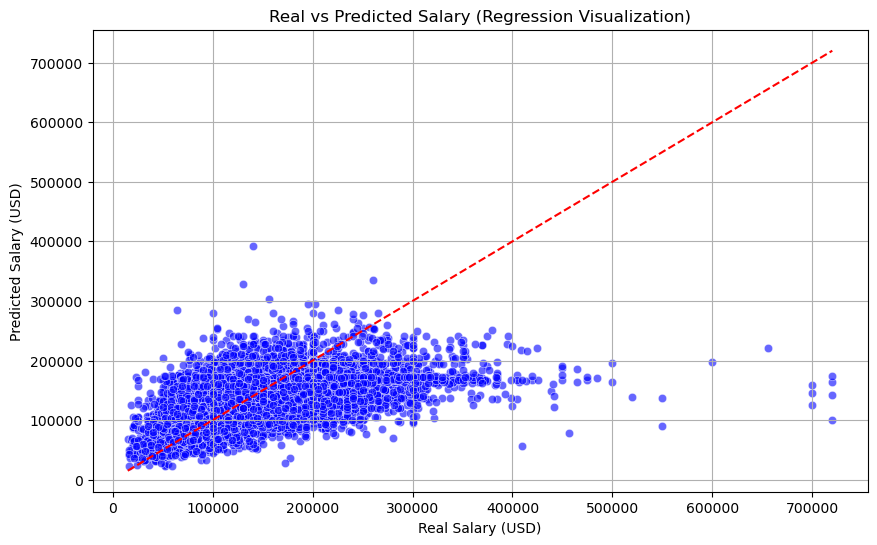


Final Model Evaluation (Without Data Leakage):
{'MAE': 43018.967204679044, 'RMSE': 57973.17517581169, 'R2': 0.21475182497696998}


In [70]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per valutare il modello
def evaluate_model(y_true, y_pred, apply_expm1=False):
    if apply_expm1:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Definizione delle feature
low_cardinality_features = ['employment_type', 'company_size', 'employee_residence', 'company_location', 'salary_currency']
high_cardinality_features = ['experience_level', 'job_title']
numerical_features = ['work_year', 'remote_ratio']

# Preprocessing pipelines
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, low_cardinality_features),
        ('oe', oe, high_cardinality_features),
        ('scale', scaler, numerical_features)
    ],
    remainder='passthrough'
)

# Inizializzazione K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# Pipeline con Visualizzazione dei Risultati
# ==========================================
print("\nPipeline without Data Leakage:")

y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(df):
    X = df.drop('salary_in_usd', axis=1)
    y = np.log1p(df['salary_in_usd'])  # Log-transform sul target
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline_no_leakage = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])

    pipeline_no_leakage.fit(X_train, y_train)
    y_pred = pipeline_no_leakage.predict(X_test)
    
    y_pred = np.expm1(y_pred)  # Riporta alla scala originale
    y_test = np.expm1(y_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Visualizzazione con Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, color='blue')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--')

plt.title("Real vs Predicted Salary (Regression Visualization)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

# Valutazione Finale del Modello
final_results = evaluate_model(np.array(y_true_all), np.array(y_pred_all))
print("\nFinal Model Evaluation (Without Data Leakage):")
print(final_results)


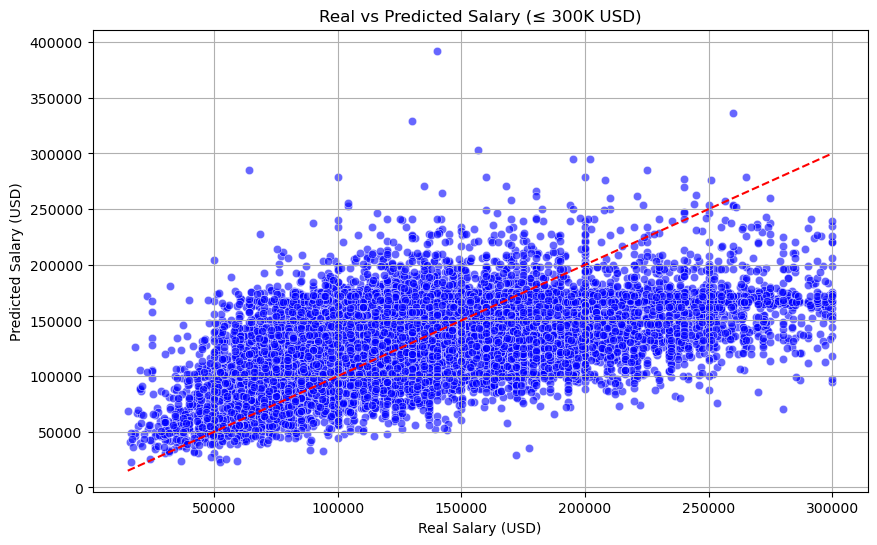

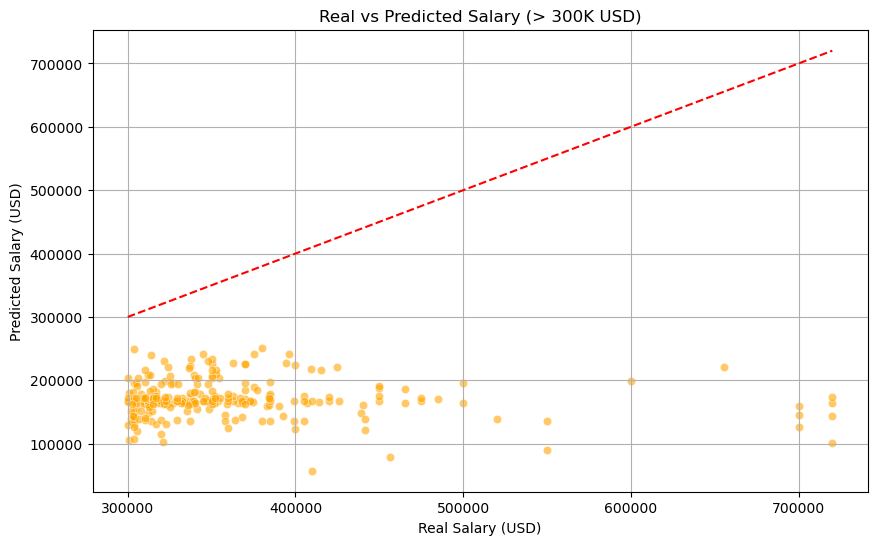


Model Evaluation for Salaries ≤ 300K USD:
{'MAE': 40131.499468832706, 'RMSE': 50633.86005552061, 'R2': 0.21922370162822802}

Model Evaluation for Salaries > 300K USD:
{'MAE': 191649.37164707747, 'RMSE': 210692.01415781223, 'R2': -6.0408770945559525}


In [71]:


# Converti le liste in array per facilità di manipolazione
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Dividi i risultati in due segmenti
mask_low = y_true_all <= 300000
mask_high = y_true_all > 300000

# Salari <= 300.000 USD
y_true_low = y_true_all[mask_low]
y_pred_low = y_pred_all[mask_low]

# Salari > 300.000 USD
y_true_high = y_true_all[mask_high]
y_pred_high = y_pred_all[mask_high]

# Valutazione separata per i due segmenti
results_low = evaluate_model(y_true_low, y_pred_low)
results_high = evaluate_model(y_true_high, y_pred_high)

# Visualizzazione - Salari <= 300.000 USD
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_low, y=y_pred_low, alpha=0.6, color='blue')
plt.plot([min(y_true_low), max(y_true_low)], [min(y_true_low), max(y_true_low)], color='red', linestyle='--')
plt.title("Real vs Predicted Salary (≤ 300K USD)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

# Visualizzazione - Salari > 300.000 USD
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_high, y=y_pred_high, alpha=0.6, color='orange')
plt.plot([min(y_true_high), max(y_true_high)], [min(y_true_high), max(y_true_high)], color='red', linestyle='--')
plt.title("Real vs Predicted Salary (> 300K USD)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

# Stampa delle metriche di valutazione
print("\nModel Evaluation for Salaries ≤ 300K USD:")
print(results_low)

print("\nModel Evaluation for Salaries > 300K USD:")
print(results_high)



## **Motivation for Splitting the Salary Data into Two Ranges**

During the analysis of the regression model results for salary prediction, a significant discrepancy emerged between predictions for **average salaries (≤ 300K USD)** and **high salaries (> 300K USD)**.  
This discrepancy highlighted that the model struggles to accurately predict extreme values.  

**Reasons for Splitting the Data:**
1. **Non-Linear Distribution of Salaries:**  
   Salary distributions are often skewed, with a large concentration of values in the lower to mid-range and fewer high-end salaries. This imbalance causes the model to generalize better for common salary ranges but poorly for rarer, higher salaries.  

2. **Model Bias Toward Majority Data:**  
   Most of the data falls below 300K USD, leading the model to optimize for this range. As a result, predictions for high salaries are systematically underestimated because the model cannot capture the patterns of this smaller subset.

3. **Distinct Patterns in High Salaries:**  
   Higher salaries (> 300K USD) may be influenced by factors that are not as relevant for lower salaries, such as executive positions, equity, or bonuses. A single model may not be flexible enough to account for these diverse influences.

---

## **Analysis of Results**

### **Evaluation for Salaries ≤ 300K USD:**  
- **Mean Absolute Error (MAE):** 40,131 USD  
- **Root Mean Squared Error (RMSE):** 50,633 USD  
- **R² Score:** 0.22  

**Interpretation:**  
The model performs reasonably well for salaries below 300K USD. The R² score, while not exceptionally high, indicates that the model captures some variance in the data. However, the error remains relatively high, suggesting there is room for improvement in predicting even the average salaries.

---

### **Evaluation for Salaries > 300K USD:**  
- **Mean Absolute Error (MAE):** 191,649 USD  
- **Root Mean Squared Error (RMSE):** 210,692 USD  
- **R² Score:** -6.04  

**Interpretation:**  
The model performs extremely poorly for high salaries. The **negative R² score** indicates that the model is worse than a simple mean baseline prediction. This suggests that the model fails to capture the underlying patterns for high-end salaries, leading to large prediction errors.

---

## **Why Does the Model Perform Poorly for Salaries Above 300K?**

1. **Lack of Sufficient Data Points:**  
   The number of data points for salaries above 300K USD is small compared to lower salaries, making it difficult for the model to learn the relevant patterns.

2. **Extreme Outliers:**  
   High salaries often represent outliers influenced by unique factors (e.g., company performance, stock options), which are hard to model with traditional regression techniques.

3. **Overfitting to Majority Class:**  
   The model overfits to the majority of the data (≤ 300K USD), neglecting the characteristics of the high-salary segment.

4. **Limited Feature Representation:**  
   Some features that drive high salaries may not be adequately represented in the dataset, limiting the model's ability to predict large values.



## Feature Selection